In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy

In [2]:
fig_kwargs = {"dpi": 200, "facecolor": "w"}

In [3]:
import pathlib

In [4]:
from datetime import datetime, timedelta

from dateutil.relativedelta import relativedelta

In [5]:
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs
from shapely.geometry import Point, Polygon

In [6]:
from dask.diagnostics import ProgressBar

In [7]:
from ICU_Water_Watch import domains, geo, utils

### Parameters 

In [8]:
dpath_subsets = "/media/nicolasf/END19101/ICU/data/glo2ho/MSWEP280/subsets"
varname = "precipitation"
domain_name = "Water_Watch"
clim_start = 1979
clim_stop = 2020

In [9]:
domain = domains.domains[domain_name]

### casts the paths from string to pathlib `Path` objects 

In [10]:
dpath_subsets = pathlib.Path(dpath_subsets)

### read the station coordinates 

In [11]:
station_coords = pd.read_csv(
    "./Stations_for_extraction.csv", index_col=None, header=None
)

In [12]:
station_coords = station_coords.dropna()

In [13]:
station_coords.columns = ["station_name", "country", "lat", "lon"]

In [14]:
station_coords.head()

,station_name,country,lat,lon
0,Funafuti,Tuvalu,-8.517488,179.200140
1,Nanumea,Tuvalu,-5.673444,176.114522
2,Nui,Tuvalu,-7.247021,177.147180
3,Nukufetau,Tuvalu,-8.027851,178.314435
4,Nukulaelae,Tuvalu,-9.370100,179.808997


In [15]:
station_name_country = station_coords.station_name + ", " + station_coords.country

### read the shapefile with the coastline

In [16]:
dpath_coastline = "/media/nicolasf/END19101/ICU/data/shapefiles/ICU/ICU_coastlines_geometries0_360/ICU_coastlines_geometries0_360.shp"

In [17]:
dpath_EEZ = "/media/nicolasf/END19101/ICU/data/shapefiles/ICU/ICU_EEZ_geometries_0_360_union/ICU_geometries0_360_union.shp"

In [18]:
coastlines = gpd.read_file(dpath_coastline)

In [19]:
EEZs = gpd.read_file(dpath_EEZ)

In [20]:
lsubsets = list(dpath_subsets.glob("*"))

In [21]:
country_dirs = [d.parts[-1] for d in lsubsets]

In [22]:
country_dirs

['Tuvalu',
 'Kiribati_Phoenix_Islands',
 'Kiribati_Line_Islands',
 'Kiribati_Gilbert_Islands',
 'Tokelau']

### list the files over the climatological period 

In [23]:
country = 'Kiribati_Phoenix_Islands'

In [24]:
lfiles = list(dpath_subsets.joinpath(country).glob("*.nc"))

In [25]:
len(lfiles)

16135

In [26]:
lfiles.sort()

In [27]:
lfiles[0]

PosixPath('/media/nicolasf/END19101/ICU/data/glo2ho/MSWEP280/subsets/Kiribati_Phoenix_Islands/MSWEP_Daily_1979-01-02.nc')

In [28]:
lfiles[-1]

PosixPath('/media/nicolasf/END19101/ICU/data/glo2ho/MSWEP280/subsets/Kiribati_Phoenix_Islands/MSWEP_Daily_2023-03-06.nc')

In [29]:
def get_date(path_to_nc):
    fname = path_to_nc.name
    date = fname.split("_")[-1].split(".")[0]
    date = datetime.strptime(date, "%Y-%m-%d")
    return date

In [30]:
dates = pd.date_range(get_date(lfiles[0]), get_date(lfiles[-1]))

In [31]:
if len(dates) != len(lfiles):
    print("problem with the number of files")

In [32]:
lfiles_clim = [
    x
    for x in lfiles
    if (get_date(x).year >= clim_start) and (get_date(x).year <= clim_stop)
]

### open the files, calculates the Q99

In [33]:
dset = xr.open_mfdataset(lfiles_clim, parallel=True)

In [34]:
dset = dset.chunk({"time": -1, "lat": "auto", "lon": "auto"})

In [35]:
dset.nbytes / 1e9

1.861909236

In [36]:
dsetm = dset.mean("time")
dsetmax = dset.max("time")
dsetq = dset.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99], "time")

In [37]:
with ProgressBar():
    dsetm = dsetm.compute()
    dsetmax = dsetmax.compute()
    dsetq = dsetq.compute()

[########################################] | 100% Completed | 109.61 s
[########################################] | 100% Completed | 113.26 s
[########################################] | 100% Completed | 118.74 s


### saves the climatologies to disk 

In [38]:
dpath_clim = dpath_subsets.joinpath(f"{country}/climatologies")

In [39]:
dpath_clim.mkdir(parents=True, exist_ok=True)

In [40]:
dsetm.to_netcdf(dpath_clim.joinpath(f"average_climatology_{clim_start}_{clim_stop}.nc"))

In [41]:
dsetmax.to_netcdf(dpath_clim.joinpath(f"max_climatology_{clim_start}_{clim_stop}.nc"))

In [42]:
dsetq.to_netcdf(
    dpath_clim.joinpath(f"quantiles_climatology_{clim_start}_{clim_stop}.nc")
)

In [ ]:
list_stats = {}

dset_corrected_l = []
dset_l = []

for fname in lfiles:
    dset = xr.open_dataset(fname)

    dset_l.append(dset)

    dsetq = dset.quantile(0.99, dim=["lat", "lon", "time"])

    dset_max = dset.max(dim=["lat", "lon", "time"])

    dset_corrected = dset.where(dset[varname] < (10 * dsetq[varname]))

    with ProgressBar():
        dset_corrected.compute()

    dset_corrected_l.append(dset_corrected)

    list_stats[dset_corrected.time.to_index()[0]] = [
        float(dsetq[varname].data),
        float(dset_max[varname].data),
        len(dset_corrected.stack(z=("lat", "lon")).dropna("z").coords["z"]),
    ]

    dset.close()

    dset_corrected.close()

In [ ]:
dset = xr.concat(dset_l, "time")

In [ ]:
dset_corrected = xr.concat(dset_corrected_l, "time")

### dataframe with the stats for each day 

In [ ]:
list_stats_df = pd.DataFrame(list_stats)

In [ ]:
list_stats_df = list_stats_df.T

In [ ]:
list_stats_df.columns = ["q99", "max", "nbgpoints"]

In [ ]:
list_stats_df.loc[:, "q99"].plot()

In [ ]:
list_stats_df.loc[:, "max"].plot()

In [ ]:
list_stats_df.loc[:, "nbgpoints"].plot()

In [ ]:
list_stats_df.loc[:, "max"].idxmax()

In [ ]:
list_stats_df.loc[:, "q99"].idxmax()

In [ ]:
list_stats_df.loc[:, "nbgpoints"].idxmin()

In [ ]:
cbar_kwargs = {"shrink": 0.7, "aspect": 60}

In [ ]:
p = dset_corrected.sel(
    time=slice(
        list_stats_df.loc[:, "max"].idxmax() - timedelta(days=5),
        list_stats_df.loc[:, "max"].idxmax() + timedelta(days=6),
    )
)[varname].plot(
    col="time",
    col_wrap=3,
    vmin=0,
    vmax=40,
    transform=ccrs.PlateCarree(),
    subplot_kws={"projection": ccrs.PlateCarree(central_longitude=180)},
    cbar_kwargs=cbar_kwargs,
    add_colorbar=False
)

for ax in p.axs.flat:
    ax.coastlines(resolution="10m")

p.fig.suptitle(country.replace("_", " "), y=1.01)

# p.fig.subplots_adjust(wspace=0.01)

p.fig.savefig(f"./figures/QC_{country}_max.png")

In [76]:
list_stats_df.columns

Index(['q99', 'max', 'nbgpoints'], dtype='object')

Text(0.5, 1.01, 'Kiribati Line Islands')

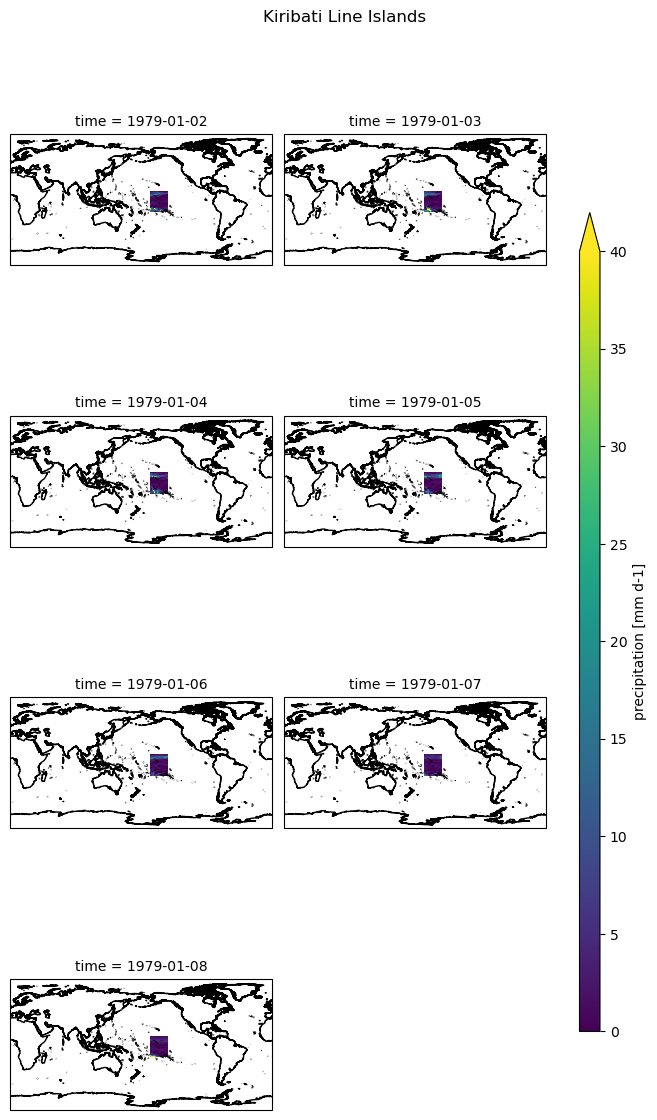

In [77]:
p = dset_corrected.sel(
    time=slice(
        list_stats_df.loc[:, "nbgpoints"].idxmax() - timedelta(days=5),
        list_stats_df.loc[:, "nbgpoints"].idxmax() + timedelta(days=6),
    )
)[varname].plot(
    col="time",
    col_wrap=2,
    vmin=0,
    vmax=40,
    transform=ccrs.PlateCarree(),
    subplot_kws={"projection": ccrs.PlateCarree(central_longitude=180)},
    cbar_kwargs=cbar_kwargs,
)

for ax in p.axs.flat:
    ax.coastlines(resolution="10m")

p.fig.suptitle(country.replace("_", " "), y=1.01)

In [59]:
# cbar_kwargs = {"shrink": 0.7}

KeyError: "no index found for coordinate 'quantile'"

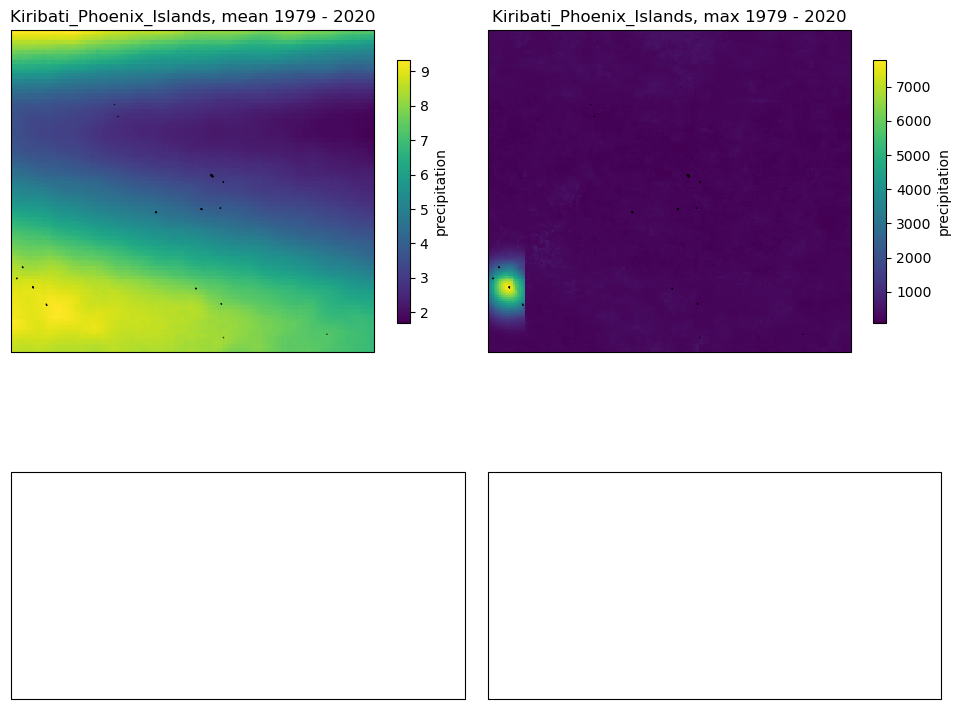

In [60]:
# f, axes = plt.subplots(
#     ncols=2,
#     nrows=2,
#     figsize=(12, 10),
#     subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)),
# )

# f.subplots_adjust(hspace=0.05, wspace=0.05)

# axes = axes.flat

# ax = axes[0]

# dsetm[varname].plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs)

# ax.coastlines(resolution="10m")

# ax.set_title(f"{country}, mean {clim_start} - {clim_stop}")

# ax = axes[1]

# dsetmax[varname].plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs)

# ax.coastlines(resolution="10m")

# ax.set_title(f"{country}, max {clim_start} - {clim_stop}")

# ax = axes[2]

# dsetq.sel(quantile=0.9)[varname].plot(
#     ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs
# )

# ax.coastlines(resolution="10m")

# ax.set_title(f"{country}, q90 {clim_start} - {clim_stop}")

# ax = axes[3]

# dsetq.sel(quantile=0.99)[varname].plot(
#     ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs
# )

# ax.coastlines(resolution="10m")

# ax.set_title(f"{country}, q99 {clim_start} - {clim_stop}")


# f.savefig(
#     f"./figures/QC_diagnostics_{country}_{clim_start}_{clim_stop}.png",
#     dpi=200,
#     bbox_inches="tight",
#     facecolor="w",
# )

In [114]:
dset_corrected = dset.where(dset[varname] < (5 * dsetq[varname].sel(quantile=0.99)))

In [118]:
dsetm_corrected = dset_corrected.mean("time")
dsetmax_corrected = dset_corrected.max("time")
# dsetq_corrected = dset_corrected.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99], 'time')

In [119]:
with ProgressBar():
    dsetm_corrected = dsetm_corrected.compute()
    dsetmax_corrected = dsetmax_corrected.compute()
    # dsetq_corrected = dsetq_corrected.compute()

[########################################] | 100% Completed | 102.70 s
[########################################] | 100% Completed | 100.01 s


In [116]:
with ProgressBar():
    dsetq_corrected = dsetq_corrected.compute()

[########################################] | 100% Completed | 116.37 s


In [ ]:
with ProgressBar():
    dsetm_corrected = dsetm_corrected.compute()

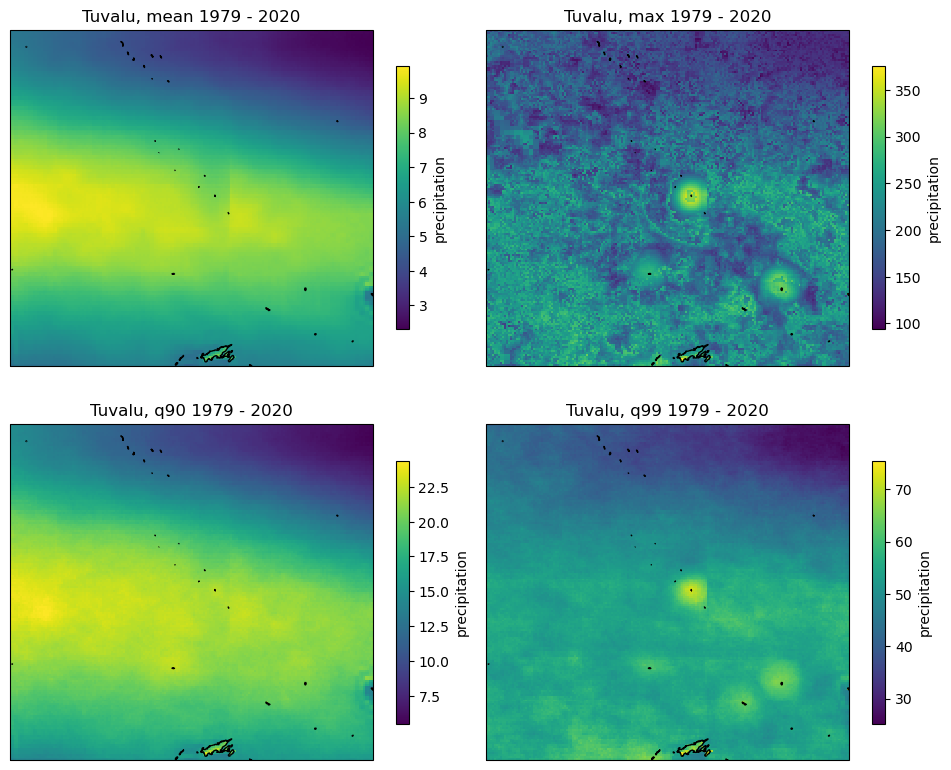

In [120]:
f, axes = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(12, 10),
    subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)),
)

f.subplots_adjust(hspace=0.05, wspace=0.05)

axes = axes.flat

ax = axes[0]

dsetm_corrected[varname].plot(
    ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs
)

ax.coastlines(resolution="10m")

ax.set_title(f"{country}, mean {clim_start} - {clim_stop}")

ax = axes[1]

dsetmax_corrected[varname].plot(
    ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs
)

ax.coastlines(resolution="10m")

ax.set_title(f"{country}, max {clim_start} - {clim_stop}")

ax = axes[2]

dsetq_corrected.sel(quantile=0.9)[varname].plot(
    ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs
)

ax.coastlines(resolution="10m")

ax.set_title(f"{country}, q90 {clim_start} - {clim_stop}")

ax = axes[3]

dsetq_corrected.sel(quantile=0.99)[varname].plot(
    ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs
)

ax.coastlines(resolution="10m")

ax.set_title(f"{country}, q99 {clim_start} - {clim_stop}")

f.savefig(
    f"./figures/QC_diagnostics_{country}_{clim_start}_{clim_stop}_corrected.png",
    dpi=200,
    bbox_inches="tight",
    facecolor="w",
)